In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import os
import sys
import polars as pl # used to read the .parquet files so its important
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Add the parent directory (or specify path to 'utils' if it's higher)
dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
sys.path.append(dir)

from dataloader.NRMSdataloader import NRMSDataLoader
from models.nrms import NRMSModelPytorch, AttLayer2_torch, SelfAttention_torch
from eval.metricEval import MetricEvaluator, AucScore, MrrScore, NdcgScore

# Now you can import from utils
from utils import add_known_user_column, add_prediction_scores
from utils import get_transformers_word_embeddings, concat_str_columns,convert_text2encoding_with_transformers, create_article_id_to_value_mapping
from utils import get_script_directory, slice_join_dataframes, truncate_history,sampling_strategy_wu2019, create_binary_labels_column

class hparams_nrms:
    # INPUT DIMENTIONS:
    title_size: int = 20
    history_size: int = 20
    # MODEL ARCHITECTURE
    head_num: int = 20
    head_dim: int = 20
    attention_hidden_dim: int = 200
    # MODEL OPTIMIZER:
    optimizer: str = "adam"
    loss: str = "cross_entropy_loss"  #["cross_entropy_loss", "BCE_loss"]
    dropout: float = 0.2
    learning_rate: float = 0.0001
    time_inclusion: str ="false" # ["false", "add", "ffnn"]

num_epochs = 30
plot_name =  "PY_soft" #["PY_sig",  "PY_soft",  "PY_add_sig",  "PY_add_soft",  "PY_ffnn_sig",  "PY_ffnn_soft"]

#["PY_sig",  "PY_soft",  "PY_add_sig",  "PY_add_soft",  "PY_ffnn_sig",  "PY_ffnn_soft"]

COLUMNS = [
    "user_id",
    "article_id_fixed",
    "article_ids_inview",
    "article_ids_clicked",
    "impression_id",
]
HISTORY_SIZE = 10
FRACTION = 0.01

basic_path = get_script_directory()

PATH = Path(basic_path+"/Data")
DATASPLIT = f"ebnerd_small"  # [ebnerd_demo, ebnerd_small, ebnerd_large]

## Initialize Train and Validation split

In [2]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select("user_id", "article_id_fixed")
        .pipe(
            truncate_history,
            column="article_id_fixed",
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on="user_id",
            how="left",
        )
    )
    return df_behaviors



df_train = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)

df_articles = pl.read_parquet(PATH.joinpath(DATASPLIT,"articles.parquet"))

## Build Word2vec embedding method

In [3]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = ["subtitle", "title"]
MAX_TITLE_LENGTH = 30 

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

article_mapping_time= create_article_id_to_value_mapping(
    df=df_articles, value_col="published_time"
)

## Initialize Data and build Dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tensorflow as tf
from typing import Any
from datetime import datetime, timedelta


def time_embedding_component(value, max_value, embedding_size):
    # Generate embedding for a given value using sine and cosine
    embedding = np.zeros(embedding_size)
    
    # Generate sine and cosine components
    for i in range(embedding_size // 2):
        embedding[2*i] = np.sin(value / (10000 ** (i / (embedding_size // 2))))
        embedding[2*i + 1] = np.cos(value / (10000 ** (i / (embedding_size // 2))))
    
    return embedding


# Compute the time embedding for a datetime
def compute_time_embedding(date_time, embedding_size=16):
    # Get the current date and time
    now = datetime(2024, 1, 1)
    
    # Compute the time difference in seconds
    time_difference = (now - date_time).total_seconds()

    # Normalize the time difference by a maximum value (e.g., seconds in a year)
    max_value = 365 * 24 * 60 * 60  # Seconds in a year
    normalized_value = time_difference / max_value
    
    # Ensure the normalized value is positive
    normalized_value = max(0, normalized_value)
    
    # Compute the time embedding
    embedding = time_embedding_component(normalized_value, max_value, embedding_size)
    
    return embedding



def compute_embedding_for_batch(his_input_time_train):

    n = his_input_time_train.shape[0]
    m = his_input_time_train.shape[1]
    time_embed_1 = torch.empty(n, m, 400)
    for i in range(n):
        for j in range(m):
            date = his_input_time_train[i,j,:]
            if date[0] == 0:
                date = [datetime(2023, 6, 1)]
            embedding = compute_time_embedding(date[0], embedding_size=400)
            time_embed_1[i,j,:] = torch.tensor(embedding)
    
    return time_embed_1



class PyTorchNRMSDataLoader(Dataset):
    def __init__(self, tf_dataloader: NRMSDataLoader, hparams_nrms):
        """
        Wraps the TensorFlow DataLoader to work with PyTorch.
        
        Args:
        - tf_dataloader: An instance of the NRMSDataLoader.
        """
        self.tf_dataloader = tf_dataloader
        self.param = hparams_nrms
    
    def __len__(self):
        # The length of the PyTorch Dataset is the same as the number of batches in TensorFlow's DataLoader
        return len(self.tf_dataloader)
    
    def __getitem__(self, idx: int) -> tuple:
        """
        Fetches a batch of data from the TensorFlow DataLoader and converts it to PyTorch format.
        
        Args:
        - idx: The index of the batch.
        
        Returns:
        - A tuple of (his_input_title, pred_input_title) and batch_y as PyTorch tensors.
        """
        # Get the batch from the TensorFlow DataLoader
        (his_input_title, pred_input_title), batch_y, (his_input_time,pred_input_time) = self.tf_dataloader[idx]
        
        his_input_time = compute_embedding_for_batch(his_input_time)
       
        pred_input_time = compute_embedding_for_batch(pred_input_time)

        # Convert numpy arrays to PyTorch tensors
        his_input_title = torch.tensor(his_input_title, dtype=torch.float32)
        pred_input_title = torch.tensor(pred_input_title, dtype=torch.float32)
        batch_y = torch.tensor(batch_y, dtype=torch.float32)


        if self.param.time_inclusion == "false":
            return (his_input_title, pred_input_title), batch_y, (None, None)
        else:
            #time_embedding_hist = torch.randn(his_input_title.size(0), his_input_title.size(1), 400)
            #time_embedding_pred = torch.randn(pred_input_title.size(0), pred_input_title.size(1), 400)
            
            return (his_input_title, pred_input_title), batch_y, (his_input_time, pred_input_time)
        


# Initialize your TensorFlow-based NRMSDataLoader (as shown in your example)
train_dataloader = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    article_dict_2=article_mapping_time,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=False,
    batch_size=8,
)

val_dataloader = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    article_dict_2=article_mapping_time,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=True,
    batch_size=8,
)

# Wrap the TensorFlow DataLoader into a PyTorch Dataset
train_pytorch_dataset = PyTorchNRMSDataLoader(train_dataloader, hparams_nrms)
val_pytorch_dataset = PyTorchNRMSDataLoader(val_dataloader, hparams_nrms)

if False:
    if hparams_nrms.time_inclusion == "false":
        for (his_input_title, pred_input_title), labels, (_,_) in train_pytorch_dataset:
            print("label",labels.shape)
    else:  
        for (his_input_title, pred_input_title), labels, (time1,time2) in train_pytorch_dataset:
            print(time1.shape)
            print(time2.shape)



## Initialize NRMS Model:

In [5]:

model = NRMSModelPytorch(
    hparams=hparams_nrms,
    word2vec_embedding=word2vec_embedding,
    seed=42,
    time_inclusion=hparams_nrms.time_inclusion
)


Using Softmax


## Training the model:

In [6]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your dataloaders (ensure they are instances of PyTorch DataLoader)
train_dataloader = train_pytorch_dataset  # Created using NRMSDataLoader
val_dataloader =val_pytorch_dataset      # Created using NRMSDataLoader

train_loss = []
train_acc = []
train_acc_0 = []
train_acc_1 = []

val_loss = []
val_acc = []
val_acc_0 = []
val_acc_1 = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_val_loss = 0
    total_train_acc = []
    total_train_acc_0 = []
    total_train_acc_1 = []
    total_val_acc = []
    total_val_acc_0 = []
    total_val_acc_1 = []
    k = 0

    # ___________________Training loop____________________
    for (his_input_title, pred_input_title), labels, (time1,time2) in train_dataloader:
        #Convert data to tensor and move to device:
        his_input_title = torch.tensor(his_input_title).to(device)
        pred_input_title = torch.tensor(pred_input_title).to(device)
        labels = torch.tensor(labels).to(device)

        #Reset gradients
        model.optimizer.zero_grad()

        #Forward pass
        predictions = model(his_input_title, pred_input_title,time1,time2)
        
        
        #Dependend on activation function we train a bit different. 
        if model.activation == "softmax":
            
            # Find index of max value in labels:
            labels_arg = torch.argmax(labels, dim=-1)
            
            #Compute Cross Entropy loss
            loss = model.criterion(predictions, labels_arg)
            
            #Save loss
            total_train_loss += loss.item()
            k = k+1

            #Compute acc
            pred_sig = torch.sigmoid(predictions)
            pred_sig = pred_sig.view(-1)
            labels = labels.view(-1)

            total_train_acc.append(np.sum( (pred_sig.detach().numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

            binary_predictions = (pred_sig >= 0.5).float()

            #    Filter for cases where labels are 1
            label_ones = labels == 1
            label_zeros = labels == 0

            # Compute accuracy for these cases
            if label_ones.sum() > 0:
                total_train_acc_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
            else:
                total_train_acc_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

            if label_zeros.sum() > 0:
                total_train_acc_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
            else:
                total_train_acc_0.append(torch.tensor(0.))
            
            #Backwards pass and opdate parameters
            loss.backward()
            model.optimizer.step()
        
        elif model.activation == "sigmoid":
            # Flatten labels
            labels = labels.view(-1)

            #Flatten predictions
            predictions = predictions.view(-1)

            #Compute BCE loss
            loss = model.criterion(predictions, labels)
            
            #Save loss
            total_train_loss += loss.item()
            k = k+1

            #Compute acc
            pred_sig = torch.sigmoid(predictions)
         
            total_train_acc.append(np.sum( (pred_sig.detach().numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

            binary_predictions = (pred_sig >= 0.5).float()

            #    Filter for cases where labels are 1
            label_ones = labels == 1
            label_zeros = labels == 0

            # Compute accuracy for these cases
            if label_ones.sum() > 0:
                total_train_acc_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
            else:
                total_train_acc_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

            if label_zeros.sum() > 0:
                total_train_acc_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
            else:
                total_train_acc_0.append(torch.tensor(0.))
            
            #Backwards pass and opdate parameters
            loss.backward()
            model.optimizer.step()

        else: 
            # Find index of max value in labels:
            labels = torch.argmax(labels, dim=-1)

            #Compute loss
            loss = model.criterion(predictions, labels)
            
            #Save loss
            total_loss += loss.item()
            k = k+1
            
            #Backwards pass and opdate parameters
            loss.backward()
            model.optimizer.step()


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_train_loss/k:.4f}")
    print(f"Acc  : {np.round(np.mean(total_train_acc)*100,2):.4f}")
    print(f"Acc_0: {np.round(np.mean(total_train_acc_0)*100,2):.4f}")
    print(f"Acc_1: {np.round(np.mean(total_train_acc_1)*100,2):.4f}")
    train_loss.append(total_train_loss/k)
    train_acc.append(np.round(np.mean(total_train_acc)*100,2))
    train_acc_1.append(np.round(np.mean(total_train_acc_1)*100,2))
    train_acc_0.append(np.round(np.mean(total_train_acc_0)*100,2))

    # ___________________Validation loop____________________

    model.eval() # set model to eval mode
    with torch.no_grad():
        
        k = 0
        for (his_input_title, pred_input_title), labels, (time1,time2)  in val_dataloader:
            #Convert data to tensor and move to device:
            his_input_title = torch.tensor(his_input_title).to(device)
            pred_input_title = torch.tensor(pred_input_title).to(device)
            labels = torch.tensor(labels).to(device)

            #Forward pass
            predictions = model(his_input_title, pred_input_title,time1,time2)

            if model.activation == "softmax":
                
                # Find index of max value in labels:
                labels_arg = torch.argmax(labels, dim=-1)
                
                #compute cross entropy loss
                loss = model.criterion_val(predictions, labels_arg)
                
                #Save loss
                total_val_loss += loss.item()
                k = k+1

                pred_sig = torch.sigmoid(predictions)
                pred_sig = pred_sig.view(-1)
                labels = labels.view(-1)

                total_val_acc.append(np.sum( (pred_sig.detach().numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

                binary_predictions = (pred_sig >= 0.5).float()

                #    Filter for cases where labels are 1
                label_ones = labels == 1
                label_zeros = labels == 0

                # Compute accuracy for these cases
                if label_ones.sum() > 0:
                    total_val_acc_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
                else:
                    total_val_acc_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

                if label_zeros.sum() > 0:
                    total_val_acc_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
                else:
                    total_val_acc_0.append(torch.tensor(0.))

            elif model.activation == "sigmoid":
                
                #Flatten label
                labels = labels.view(-1)  

                #flatten prediction
                predictions = predictions.view(-1)  
                
                #Compute BCE loss
                loss = model.criterion(predictions, labels)
            
                total_val_loss += loss.item()
                k = k+1

                #Compute acc
                pred_sig = torch.sigmoid(predictions)
         
                total_val_acc.append(np.sum( (pred_sig.detach().numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

                binary_predictions = (pred_sig >= 0.5).float()

                #    Filter for cases where labels are 1
                label_ones = labels == 1
                label_zeros = labels == 0

                # Compute accuracy for these cases
                if label_ones.sum() > 0:
                    total_val_acc_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
                else:
                    total_val_acc_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

                if label_zeros.sum() > 0:
                    total_val_acc_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
                else:
                    total_val_acc_0.append(torch.tensor(0.))
            else:
                # Find index of max value in labels:
                labels = torch.argmax(labels, dim=-1)
            
                #compute cross entropy loss
                loss = model.criterion(predictions, labels)

                #Save loss
                val_loss += loss.item()
                k = k+1

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_val_loss/k:.4f}")
        print(f"Acc  : {np.round(np.mean(total_val_acc)*100,2):.4f}")
        print(f"Acc_0: {np.round(np.mean(total_val_acc_0)*100,2):.4f}")
        print(f"Acc_1: {np.round(np.mean(total_val_acc_1)*100,2):.4f}")
        val_loss.append(total_val_loss/k)
        val_acc.append(np.round(np.mean(total_val_acc)*100,2))
        val_acc_1.append(np.round(np.mean(total_val_acc_1)*100,2))
        val_acc_0.append(np.round(np.mean(total_val_acc_0)*100,2))



Epoch 1/30, Loss: 1.6081
Acc  : 22.1100
Acc_0: 3.2900
Acc_1: 97.4000
Epoch 1/30, Loss: 0.0000
Acc  : 11.0900
Acc_0: 2.4300
Acc_1: 99.1500
Epoch 2/30, Loss: 1.5994
Acc  : 28.4900
Acc_0: 11.3500
Acc_1: 97.0600
Epoch 2/30, Loss: 0.0000
Acc  : 14.9500
Acc_0: 7.0600
Acc_1: 95.2800
Epoch 3/30, Loss: 1.5913
Acc  : 36.5200
Acc_0: 22.1300
Acc_1: 94.1100
Epoch 3/30, Loss: 0.0000
Acc  : 20.7400
Acc_0: 13.9000
Acc_1: 90.4400
Epoch 4/30, Loss: 1.5832
Acc  : 43.2800
Acc_0: 31.3800
Acc_1: 90.8700
Epoch 4/30, Loss: 0.0000
Acc  : 26.8300
Acc_0: 21.2500
Acc_1: 83.9100
Epoch 5/30, Loss: 1.5748
Acc  : 47.5200
Acc_0: 37.5400
Acc_1: 87.4600
Epoch 5/30, Loss: 0.0000
Acc  : 32.6500
Acc_0: 28.2600
Acc_1: 77.6600
Epoch 6/30, Loss: 1.5660
Acc  : 51.6200
Acc_0: 43.2300
Acc_1: 85.1800
Epoch 6/30, Loss: 0.0000
Acc  : 37.6400
Acc_0: 34.4400
Acc_1: 70.6700
Epoch 7/30, Loss: 1.5577
Acc  : 53.7000
Acc_0: 46.2400
Acc_1: 83.5600
Epoch 7/30, Loss: 0.0000
Acc  : 41.6900
Acc_0: 39.4800
Acc_1: 64.8500
Epoch 8/30, Loss: 1.548

## Evaluate Model

In [7]:
#Initialize metrics for validation:
mrr_metric = MrrScore()
Ndc_5_metric = NdcgScore(k=5)
Ndc_10_metric = NdcgScore(k=10)
auc_metric = AucScore()

#set model to eval mode
model.eval()

with torch.no_grad():
    #initialize empty list to save values.
    y_true_total = []
    y_pred_total = []
    acc_total = []
    total_predictions = []
    total_1_prediction = []
    acc_label_1 = []
    acc_label_0 = []

    for (his_input_title, pred_input_title), labels, (time1,time2) in val_dataloader:
        # Move tensors to the appropriate device
        # Convert numpy arrays to PyTorch tensors and move to the appropriate device
        his_input_title = torch.tensor(his_input_title).to(device)
        pred_input_title = torch.tensor(pred_input_title).to(device)
        labels = torch.tensor(labels).to(device)

        # Forward pass
        predictions = model(his_input_title, pred_input_title,time1,time2)

        if model.activation == "sigmoid":
            predictions = torch.sigmoid(predictions)
            # Flatten the labels to match batch size (flatten into a vector)
            labels = labels.view(-1)  
            
            # Flatten predictions
            predictions = predictions.view(-1)

            total_predictions.append(labels.numpy().size)   
            total_1_prediction.append(np.sum(labels.numpy() == 1))
            
            #Save labels and predictions for AUC computations
            y_pred_total.append( predictions.numpy()   )
            y_true_total.append( labels.numpy() )
            
            #Compute accuracy of batch
            acc_total.append(np.sum( (predictions.numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

            # Convert predictions to binary values using a threshold (e.g., 0.5 for sigmoid)
            binary_predictions = (predictions >= 0.5).float()

            #    Filter for cases where labels are 1
            label_ones = labels == 1
            label_zeros = labels == 0

            # Compute accuracy for these cases
            if label_ones.sum() > 0:
                acc_label_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
            else:
                acc_label_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

            if label_zeros.sum() > 0:
                acc_label_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
            else:
                acc_label_0.append(torch.tensor(0.)) 
        
        elif model.activation == "softmax":
            predictions = torch.sigmoid(predictions)
            labels = labels.view(-1)  
            
            # Flatten predictions
            predictions = predictions.view(-1)

            total_predictions.append(labels.numpy().size)   
            total_1_prediction.append(np.sum(labels.numpy() == 1))
            
            #Save labels and predictions for AUC computations
            y_pred_total.append( predictions.numpy()   )
            y_true_total.append( labels.numpy() )
            
            #Compute accuracy of batch
            acc_total.append(np.sum( (predictions.numpy() > 0.5) == labels.numpy()) / len(labels.numpy()) )

            # Convert predictions to binary values using a threshold (e.g., 0.5 for sigmoid)
            binary_predictions = (predictions >= 0.5).float()

            #    Filter for cases where labels are 1
            label_ones = labels == 1
            label_zeros = labels == 0

            # Compute accuracy for these cases
            if label_ones.sum() > 0:
                acc_label_1.append((binary_predictions[label_ones] == labels[label_ones]).float().mean())
            else:
                acc_label_1.append(torch.tensor(0.) ) # Handle cases where there are no label_ones

            if label_zeros.sum() > 0:
                acc_label_0.append((binary_predictions[label_zeros] == labels[label_zeros]).float().mean())
            else:
                acc_label_0.append(torch.tensor(0.))
    

    # Compute metrics
    auc_value = auc_metric.calculate(y_true_total, y_pred_total)
    mrr_value = mrr_metric.calculate(y_true_total, y_pred_total)
    Ndc5_value = Ndc_5_metric.calculate(y_true_total, y_pred_total)
    Ndc10_value = Ndc_10_metric.calculate(y_true_total, y_pred_total)
    
    print("Average AUC Score:", auc_value)
    print("Average Mrr Score:", mrr_value)
    print("Average NDC=5 Score:", Ndc5_value)
    print("Average NDC=10 Score:", Ndc10_value)
    
    print("")
    acc = np.round(np.mean(acc_total)*100,2)
    
    print("Average overall Accuracy:",  acc ,"%")
    if model.activation == "sigmoid" or model.activation == "softmax":
        average_label_1_accuracy = torch.mean(torch.stack(acc_label_1)) 
        average_label_0_accuracy = torch.mean(torch.stack(acc_label_0)) 
        acc_1 =np.round(average_label_1_accuracy.item()*100,2)
        acc_0 =np.round(average_label_0_accuracy.item()*100,2)
        print("Average 1-label Accuracy:",acc_1,"%")
        print("Average 0-label Accuracy:",acc_0,"%")

total_results = [auc_value, mrr_value, Ndc5_value, Ndc10_value,acc,acc_1,acc_0 ]
total_results_string = ["AUC", "Mrr", "ndc5", "ndc10", "acc", "acc_1", "acc_0"]

Average AUC Score: 0.5349801736575347
Average Mrr Score: 0.05795255670705912
Average NDC=5 Score: 0.08955308512047835
Average NDC=10 Score: 0.10501570481235173

Average overall Accuracy: 64.44 %
Average 1-label Accuracy: 35.91 %
Average 0-label Accuracy: 67.26 %


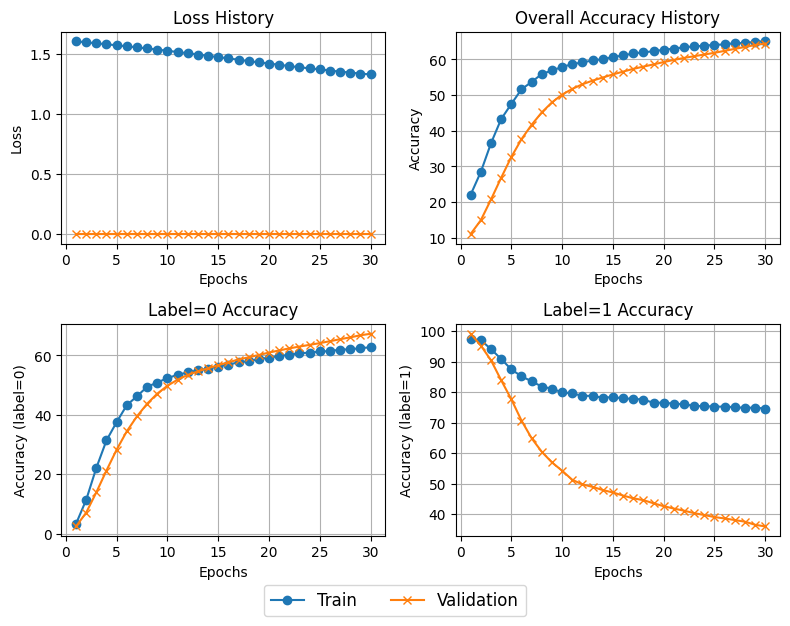

In [8]:
epochs = range(1, len(train_loss) + 1)
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot 1: Train/Validation Loss
axes[0, 0].plot(epochs, train_loss, label='Train Loss', marker='o')
axes[0, 0].plot(epochs, val_loss, label='Validation Loss', marker='x')
axes[0, 0].set_title('Loss History')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# Plot 2: Train/Validation Accuracy
axes[0, 1].plot(epochs, train_acc, label='Train Accuracy', marker='o')
axes[0, 1].plot(epochs, val_acc, label='Validation Accuracy', marker='x')
axes[0, 1].set_title('Overall Accuracy History')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True)

# Plot 3: Train/Validation Accuracy for label 0
axes[1, 0].plot(epochs, train_acc_0, label='Train Accuracy (label=0)', marker='o')
axes[1, 0].plot(epochs, val_acc_0, label='Validation Accuracy (label=0)', marker='x')
axes[1, 0].set_title('Label=0 Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy (label=0)')
axes[1, 0].grid(True)

# Plot 4: Train/Validation Accuracy for label 1
axes[1, 1].plot(epochs, train_acc_1, label='Train Accuracy (label=1)', marker='o')
axes[1, 1].plot(epochs, val_acc_1, label='Validation Accuracy (label=1)', marker='x')
axes[1, 1].set_title('Label=1 Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy (label=1)')
axes[1, 1].grid(True)

# Adjust layout to make room for the legend
fig.subplots_adjust(bottom=0.15)  # Add space below the plots for the legend

# Add a single legend below the plots
fig.legend(['Train', 'Validation'], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.05))  # Adjust bbox

# Adjust layout and save the plot
plt.tight_layout()

# Save the plot
plt.savefig(dir+'/graphics/'+plot_name+".png", dpi=300)

# Display the plot
plt.show()


In [9]:
import pickle


results = {
    "train_losses": train_loss,
    "val_losses": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
    "train_acc_1": train_acc_1,
    "val_acc_1": val_acc_1,
    "train_acc_0": train_acc_0,
    "val_acc_0": val_acc_0,
    "total_results": total_results,
    "total_results_string": total_results_string
}

# Save the loss to a .pkl file
with open(dir+'/saved_loss/'+plot_name+".pkl", 'wb') as f:
    pickle.dump(results, f)

